### Transfer learning models:

This notebook is about transfer learning models and the reinforcement learning agent to determine whether to use the transfer learner or an active learning policy.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz
import src.reinforcement as rl
import src.data as d 
from src.models import logreg, CNN, AgentRL
# import active_learning as al
# import viz
# import reinforcement as rl
# import data as d 
# from models import logreg, CNN, AgentRL

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.models as tmodels
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.distributions import Categorical

%matplotlib inline

In [2]:
# Get raw datasets - MNIST
d = imp.reload(d)
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

# Get raw dataset - USPS
percent_test = 0.3
usps_batch = 64
usps_set = d.get_usps('usps/usps_all.mat', size=(28,28))
usps_x, usps_y, usps_test_x, usps_test_y = al.get_dataset_split(usps_set,int(len(usps_set)*percent_test))
usps_test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_test_x, usps_test_y), \
                                               batch_size=len(usps_test_y),shuffle=False)
usps_train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_x, usps_y), \
                                               batch_size=usps_batch,shuffle=True)


In [3]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

In [4]:
# Get resnet from pytorch (trained on imagenet)
# model_in = tmodels.resnet18(pretrained=True)
# model_in

In [6]:
# Get pretrained usps handwritten classifier - completely trained 
# Warnings causes by pytorch versioning issues with 0.3.1 on conda GPU vs 0.3.0 on conda CPU
# model_usps = torch.load('paul_models/usps_model.pt')
# print('USPS training accuracy:',al.accuracy(model_usps, usps_x, usps_y))
# print('USPS test accuracy:',al.accuracy(model_usps, usps_test_x, usps_test_y))

A Jupyter Widget

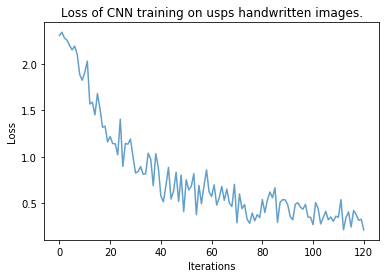

Training accuracy: 0.868831168831
Test accuracy: 0.874242424242


In [7]:
# Get partially trained USPS model 

# Define the CNN model
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

def train_usps(epochs, model, opt, lossf, train_loader):
    losses,n_itr = [],0
    for e in tqdm(range(epochs)):
        for batch_x, batch_y in train_loader:
            batch_x = Variable(batch_x.cuda()) if use_cuda else Variable(batch_x)
            batch_y = Variable(batch_y.cuda()) if use_cuda else Variable(batch_y)

            result = model(batch_x)
            loss = lossf(result, batch_y)
            opt.zero_grad()
            loss.backward()
            opt.step()

            n_itr+=1
            losses.append(loss)

    if use_cuda:
        losses = [itm.data.cpu().numpy()[0] for itm in losses]
    else:, 
        losses = [itm.data.numpy()[0] for itm in losses]

    return list(range(n_itr)), losses

# Get raw dataset - USPS
percent_test = 0.3
usps_batch = 64
usps_set = d.get_usps('../notebooks/usps/usps_all.mat', size=(28,28))
usps_x, usps_y, usps_test_x, usps_test_y = al.get_dataset_split(usps_set,int(len(usps_set)*percent_test))
usps_test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_test_x, usps_test_y), \
                                            batch_size=len(usps_test_y),shuffle=False)
usps_train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_x, usps_y), \
                                            batch_size=usps_batch,shuffle=True)
    
# train simple learner on USPS and use as the transfer learner 
usps_epochs = 1
use_cuda = torch.cuda.is_available()
usps_model = CNN().cuda() if use_cuda else CNN()
usps_opt = optim.Adam(usps_model.parameters(), lr=0.01)
usps_loss = nn.NLLLoss()

n_itr, usps_losses = train_usps(1, usps_model, usps_opt, usps_loss, usps_train_loader)

# Analysis of model 
plt.plot(n_itr, usps_losses, alpha=0.7)
plt.title('Loss of CNN training on usps handwritten images.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

print('Training accuracy:',al.accuracy(usps_model, usps_x, usps_y, use_cuda))
print('Test accuracy:',al.accuracy(usps_model, usps_test_x, usps_test_y, use_cuda))

### Now that the transfer learners are loaded we are ready to reinforcement learn:

for a given state of the model.. meaning all potential training points, labeled and unlabeled and our predictions on those, is it better to active learn with policy $y$ and continue training our original model or is it better to transfer a different model and retrain the final layer.


## Implementation: 

I need to implement a system that reinforcement learns two options.  

1. Train more on the source dataset and then perform $n$ epochs of training on the existing points in the target dataset and predict on the validation in the target 
2. Use active learning policies to select the next $k$ points in the target set for labeling and then train for $n$ epochs on the target dataset and predict on the validation set in the target.

##### Decisions:

Decide on if you want the reward to be $\Delta$ accuracy or accuracy itself.

In [6]:
# Make the RL agent to interact with the environment 
class AgentRL(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_policies):
        super(AgentRL, self).__init__()
        self.num_policies = num_policies
        self.inner_layer = nn.Linear(inpt_dim, hidden_dim)
        self.outer_layer = nn.Linear(hidden_dim, num_policies)
        self.rewards = []
        self.saved_log_probs = []
        
    def forward(self, x):
        x = x.view(1,-1)
        x = F.relu(self.inner_layer(x))
        x = self.outer_layer(x)
        return F.softmax(x, dim=1)

In [7]:
agent = AgentRL(int(len(train_x)*10),128, 2) # 2 for the 1 AL policy and one TL policy
optimizer_rl = optim.Adam(agent.parameters(), lr=1e-2)


### Reset the envorinment
experiment, model_try = self.reset_al(lr=lr)

# Calculate the initial state
train_tensor = self.train_x.cuda() if self.use_cuda else self.train_x
state = model_try(Variable(train_tensor))

# Run the experiment up to training on 1000 points
policies,track_reward = [],[]
for t in range(self.al_itrs):
    action = self.select_action(agent, state)
    if policy_key[action]=='transfer':
        
    policies.append(policy_key[action])
    _, reward = experiment.active_learn(policy=policy_key[action])
     track_reward.append(reward)
    state = model_try(Variable(train_tensor))
    agent.rewards.append(reward[0])

policies_chosen.append(policies)
rewards_total.append(np.array(track_reward))
running_reward = running_reward * 0.99 + t * 0.01
self.finish_experiment(agent, optimizer_agent, gamma=0.99)





def run_experiments(self, agent, optimizer_agent, policy_key, n_experiments, lr=0.01):
    running_reward = 1.0
    policies_chosen, rewards_total = [],[]
    for i_exp in tqdm(range(n_experiments)):
        ### Reset the envorinment
        experiment, model_try = self.reset_al(lr=lr)

        # Calculate the initial state
        train_tensor = self.train_x.cuda() if self.use_cuda else self.train_x
        state = model_try(Variable(train_tensor))

        # Run the experiment up to training on 1000 points
        policies,track_reward = [],[]
        for t in range(self.al_itrs):
            action = self.select_action(agent, state)
            policies.append(policy_key[action])
            _, reward = experiment.active_learn(policy=policy_key[action])
             track_reward.append(reward)
            state = model_try(Variable(train_tensor))
            agent.rewards.append(reward[0])

        policies_chosen.append(policies)
        rewards_total.append(np.array(track_reward))
        running_reward = running_reward * 0.99 + t * 0.01
        self.finish_experiment(agent, optimizer_agent, gamma=0.99)

    return policies_chosen, np.array(rewards_total